# BACTERIA

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
# import packages
import os
import qiime2 as q2
import pandas as pd
import dokdo
import matplotlib.pyplot as plt
from qiime2.plugins import feature_classifier
from qiime2.plugins.taxa.visualizers import barplot
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.taxa.methods import filter_seqs
from qiime2.plugins.metadata.visualizers import tabulate

In [3]:
# define workdir
%env WORKDIR /home/nezapa/qiime-thesis
WORKDIR = os.environ.get("WORKDIR")

env: WORKDIR=/home/nezapa/qiime-thesis


In [4]:
# import data
denoisetable = q2.Artifact.load('./results/denoisetable.qza')
rep_seqs = q2.Artifact.load('./results/rep_seqs.qza')
denoising_stats = q2.Artifact.load('./results/denoising_stats.qza')
sample_metadata = q2.Metadata.load('../00.sample-metadata.tsv')

## TAXONOMIC ANALYSIS

In [5]:
# load classifier data
classifier = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/classifier-B-341F_802R.qza')
reference_reads = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/ref-seqs_341F_802R.qza')
reference_taxonomy = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/silva-138-99-tax.qza')

In [6]:
# define model choices
models = {
    'sklearn': feature_classifier.methods.classify_sklearn,
    'vsearch': feature_classifier.methods.classify_consensus_vsearch,
    'blast': feature_classifier.methods.classify_consensus_blast,
    'hybrid': feature_classifier.pipelines.classify_hybrid_vsearch_sklearn
}

In [7]:
# choose model, run for each model_name
model_name = "sklearn"
model = models[model_name]

In [8]:
# classify the seqences using different classifiers
# run once for each model
# this step might take some time

if os.path.exists(f'./results/taxonomy_{model_name}.qza'):
    taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')
else:
    if model_name == "sklearn":
        taxonomy = model(
            reads = rep_seqs,
            classifier = classifier,
            n_jobs=4
        )
        
    elif model_name == "vsearch":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            threads = 15
        )
    elif model_name == "blast":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy
            )
    elif model_name == "hybrid":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            classifier = classifier,
            threads = 2,
            prefilter = False
            )
    else:
        print(f"model name {model_name} doesn't exist")
    
    taxonomy = taxonomy.classification
    taxonomy.save(f'./results/taxonomy_{model_name}.qza')

In [9]:
# merge all taxonomy classifications
for idx, model_name in enumerate(models.keys()):
    model_df = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza').view(pd.DataFrame)
    model_df.columns = [f'{col}_{model_name}' for col in model_df.columns]
    if idx == 0:
        res_df = model_df.copy()
    else:
        res_df = res_df.merge(model_df, on = 'Feature ID')

In [10]:
# view merged df as q2 viz
res_df_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(res_df)).visualization
res_df_viz.save('./results/res_df_viz.qzv')
res_df_viz

<visualization: Visualization uuid: 5c966131-83e6-4541-9a53-ce14d4dd99d3>

In [11]:
# choose a classifier
model_name = "sklearn"
taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')

In [12]:
# load classification results of a chosen classifier as metadata and view them
taxonomy_metadata = taxonomy.view(q2.Metadata)  # or pd.DataFrame
q2.plugins.metadata.visualizers.tabulate(taxonomy_metadata).visualization

<visualization: Visualization uuid: 4e21e9e2-3408-4cef-b3c9-3fde42c6bdd0>

In [13]:
# load rep_seqs as metadata
rep_seqs_mtdt = rep_seqs.view(q2.Metadata)

# merge dataframes in the background (appends new column)
annotated_taxonomy_metadata = taxonomy_metadata.merge(rep_seqs_mtdt)

# visualize merged dataframes as metadata viz
q2.plugins.metadata.visualizers.tabulate(annotated_taxonomy_metadata).visualization

<visualization: Visualization uuid: c3dd8ed1-2ecb-4f96-8a8e-2b18ca7deb20>

### FILTER BY TAXONOMY

In [14]:
# filter denoisetable, keep only d_Bacteria
denoisetable_ba = filter_table(
    table = denoisetable,
    taxonomy = taxonomy, 
    include = 'd__Bacteria'
)
denoisetable_ba.filtered_table.save('./results/denoisetable_ba.qza')

'./results/denoisetable_ba.qza'

In [15]:
# filter rep_seqs, keep only d_Baceria
rep_seqs_ba = filter_seqs(
    sequences = rep_seqs,
    taxonomy = taxonomy,
    include = 'd__Bacteria'
)

rep_seqs_ba.filtered_sequences.save('./results/rep_seqs_ba.qza')

'./results/rep_seqs_ba.qza'

In [16]:
# filter unassigned
unassigned_denoisetable = filter_table(
    table = denoisetable,
    taxonomy = taxonomy, 
    exclude = 'd__Bacteria'
)

### TAXA PER SPECIMEN

In [17]:
# load denoise as dataframe and transpose (feature id is index), add name to index
denoise_df = denoisetable_ba.filtered_table.view(view_type = pd.DataFrame).T
denoise_df.index.name = 'id'

# load annotated data as df
annotated_df = annotated_taxonomy_metadata.to_dataframe()

# merge the two using indices of both dataframes
merged_df = denoise_df.merge(annotated_df['Taxon'], left_index=True, right_index=True)

# set Taxon column as index and show transposed
taxon_df = merged_df.set_index('Taxon').T

In [18]:
# define function extract lvl using regex (regular expressions)
import re
def extract_level(tax, level_prefix, null_data = '/'):
    g = re.findall(fr'({level_prefix}[^;|^$]*)(?=;|$)', tax)
    if len(g) == 0:
        return null_data
    
    return g[0].replace(level_prefix, '')

In [19]:
# choose a sample 
# run once for each sample
subject = 'P19A'
taxon_df.loc[[subject]].T.reset_index().query(f'{subject} > 0.0').value_counts('Taxon')

# define custom_df, get rid of Unassigned
custom_df = taxon_df.loc[[subject]].T.reset_index()
custom_df = custom_df.query(f'Taxon != "Unassigned" and {subject} > 0')

custom_df['Domain'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='d__'))
custom_df['Phylum'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='p__'))
custom_df['Class'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='c__'))
custom_df['Order'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='o__'))
custom_df['Family'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='f__'))
custom_df['Genus'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='g__'))
custom_df['Species'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='s__'))

columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
# columns = ['Order', 'Family', 'Genus', 'Species']
taxa_per_species = custom_df.groupby(columns).sum()
# print(taxa_per_species.to_latex())
taxa_per_species

P19A
Domain   Phylum            Class               Order                          Family               Genus                       Species                             
Bacteria /                 /                   /                              /                    /                           /                              317.0
         Actinobacteriota  Acidimicrobiia      Microtrichales                 Ilumatobacteraceae   CL500-29_marine_group       uncultured_Ilumatobacter         2.0
         Bacteroidota      Bacteroidia         Bacteroidales                  Bacteroidaceae       Bacteroides                 /                               57.0
                                                                                                                               Bacteroides_fragilis            12.0
                                                                                                                               Bacteroides_massiliensis        83.0
                                                                                                                               Bacteroides_ovatus               7.0
                                                                              Marinifilaceae       Butyricimonas               /                                1.0
                                                                                                   Odoribacter                 Odoribacter_splanchnicus         6.0
                                                                              Tannerellaceae       Parabacteroides             Parabacteroides_merdae          18.0
                                               Cytophagales                   Spirosomaceae        Arcicella                   uncultured_bacterium             8.0
                                               Flavobacteriales               Flavobacteriaceae    Flavobacterium              /                                2.0
                                               Sphingobacteriales             NS11-12_marine_group NS11-12_marine_group        uncultured_Flexibacteraceae      1.0
         Firmicutes        Bacilli             Lactobacillales                Lactobacillaceae     Lactobacillus               /                                2.0
                                                                              Leuconostocaceae     Leuconostoc                 /                                4.0
                                                                              Streptococcaceae     Lactococcus                 Lactococcus_piscium             17.0
                           Clostridia          Lachnospirales                 Lachnospiraceae      Agathobacter                /                                7.0
                                                                                                   Anaerostipes                /                                5.0
                                                                                                   Blautia                     /                                2.0
                                                                                                   Roseburia                   /                                3.0
                                                                                                   [Eubacterium]_eligens_group /                                2.0
                                               Oscillospirales                Ruminococcaceae      Faecalibacterium            /                                7.0
                           Negativicutes       Veillonellales-Selenomonadales Veillonellaceae      Dialister                   Dialister_invisus                4.0
         Proteobacteria    Alphaproteobacteria Caulobacterales                Caulobacteraceae     Brevundimonas               Brevundimonas_mediterranea       2.0
                                               Sphingomonad

### VISUALIZATIONS

In [20]:
# visualise classifications in qiime2
taxa_bar_plot = barplot(
    table = denoisetable_ba.filtered_table,
    taxonomy = taxonomy,
    metadata = sample_metadata
).visualization

In [21]:
# save taxa_bar_plot in results folder
taxa_bar_plot.save('./results/taxa_bar_plots.qzv')

'./results/taxa_bar_plots.qzv'

In [22]:
# visualise taxa bar plot - interacive taxa bar plot visualisation
taxa_bar_plot

<visualization: Visualization uuid: f72cae03-123d-4329-abe0-44c61963407d>

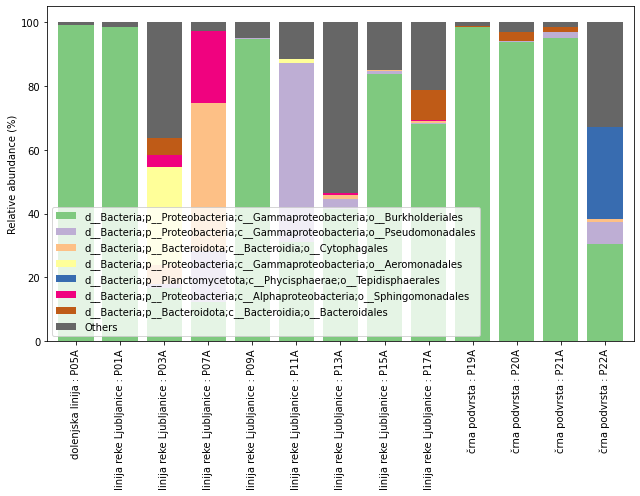

In [23]:
# taxa abundance plot with dokdo
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    level=4,
    count=8,
    figsize=(9, 7),
    by=['population'],
    label_columns=['population', 'sample-id'],
    sort_by_mean2=False
)

plt.tight_layout()

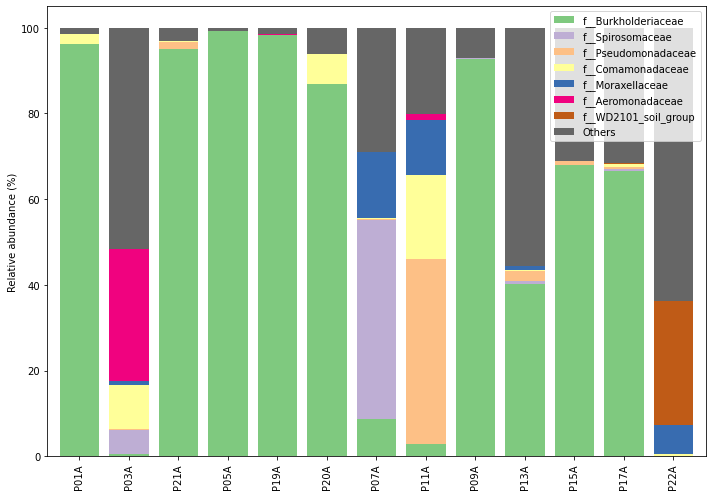

In [24]:
# show 7 most abundant genera plus 'Others' with count = 8
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(10, 7),
    level=5,
    count=8,
    legend_short=True,
    by=['year'],
    label_columns=['sample-id'],
    sort_by_mean2=False
)

plt.tight_layout()

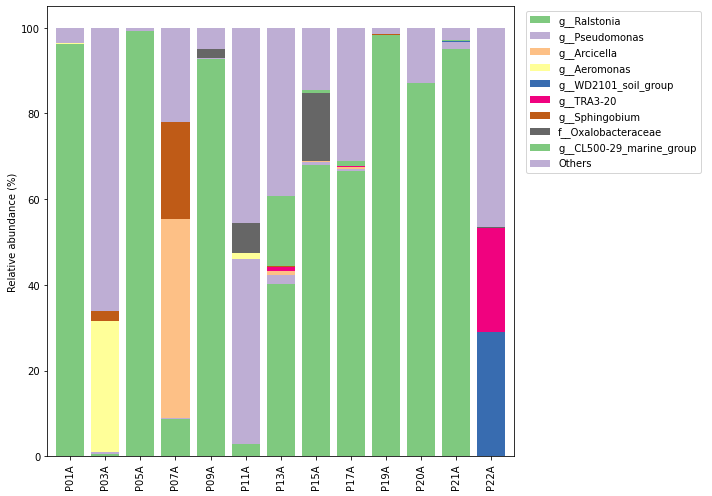

In [25]:
# plot the legent separately
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=10,
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=10,
    legend_short=True
)

handles, labels = ax2.get_legend_handles_labels()

ax2.clear()
ax2.legend(handles, labels)
ax2.axis('off')

plt.tight_layout()

In [26]:
def label_filter(lbl):
    if lbl.count(';') == 0:
        return lbl
    
    lbl_split = lbl.split(';')
    
    new_label = []
    for piece in lbl_split[::-1]:
        new_label.append(piece)
        if 'uncultured' not in piece and piece != '__':
            break
            
    return ';'.join(new_label[::-1][:2])

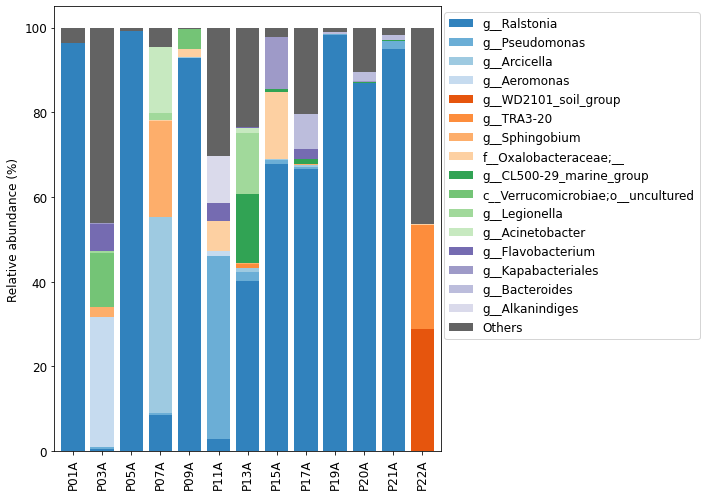

In [27]:
# use a different colour map
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=17,
    cmap_name='tab20c',
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=17,
    cmap_name='tab20c',
    legend_short=False
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

# custom properties
ax1.tick_params(labelsize=12)  # reset rotation
ax1.yaxis.label.set_size(12)


ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

plt.tight_layout()
plt.savefig('./results/proteus_all_16taxa.png')

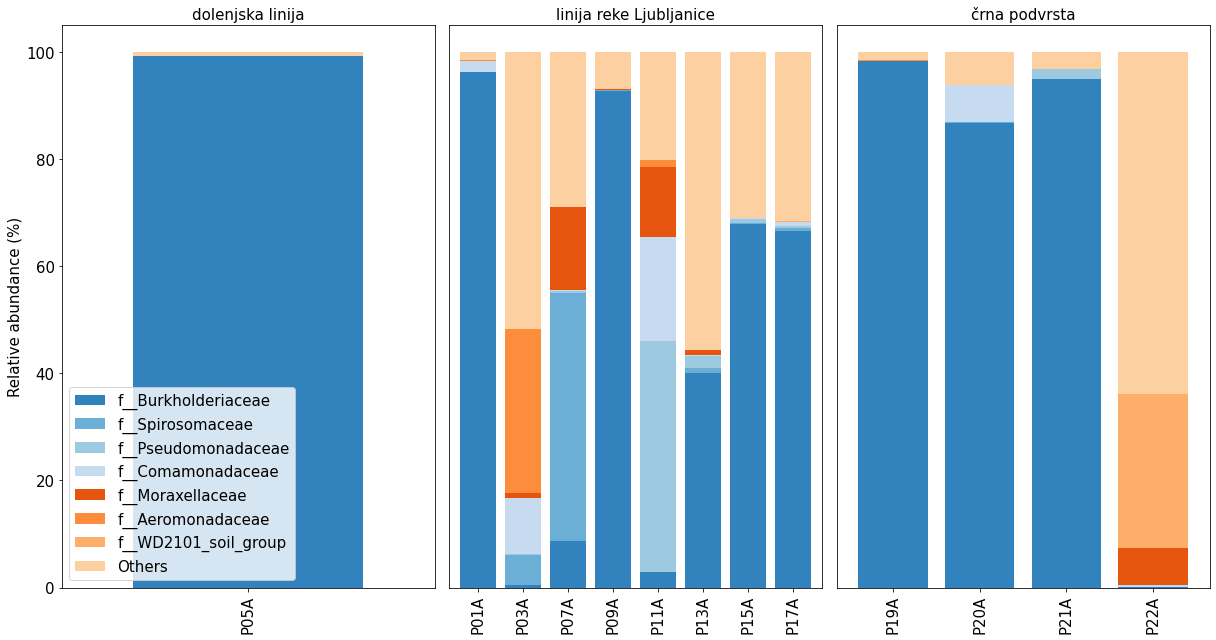

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(17, 9))

groups = ['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta']
kwargs = dict(level=5, count=8, sort_by_mean2=False)

for i, group in enumerate(groups):
    dokdo.taxa_abundance_bar_plot(
        taxa_bar_plot,
        ax=axes[i],
        include_samples={'population': [group]},
        cmap_name='tab20c',
        legend_short=True,
        legend=True if i == 0 else False,
        **kwargs # da razbije dictionary se uporabi **
    )
    if i != 0:
        axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(group)

# custom properties
for idx, ax in enumerate(axes):
    ax.tick_params(axis='x', labelrotation = 90, labelsize=15)  # reset rotation
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.label.set_size(15)
    ax.title.set_size(15)
    
    if idx == 0:
        ax.legend(fontsize=15)
    
plt.tight_layout()
plt.savefig('./results/proteus_all_populations.png')

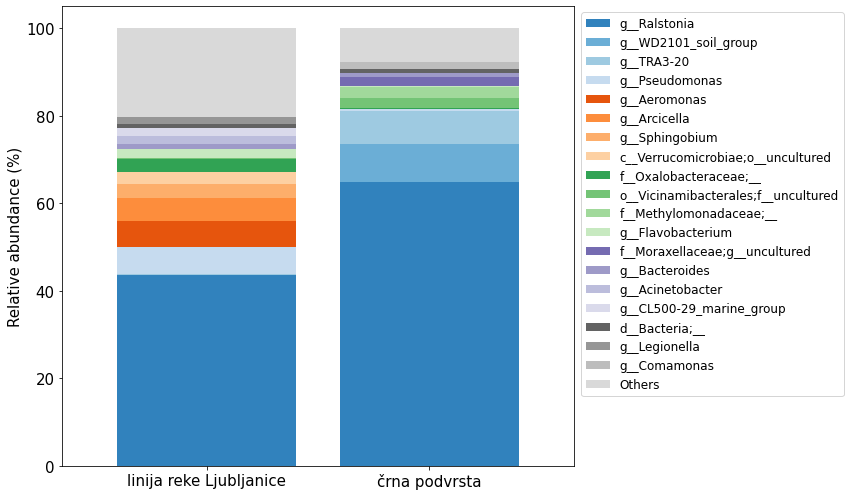

In [29]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend=False,
    cmap_name='tab20c'
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend_short=False,
    cmap_name='tab20c'
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

# custom properties
ax1.tick_params(labelrotation = 0, labelsize=15)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/proteus_all_populations_together.png')

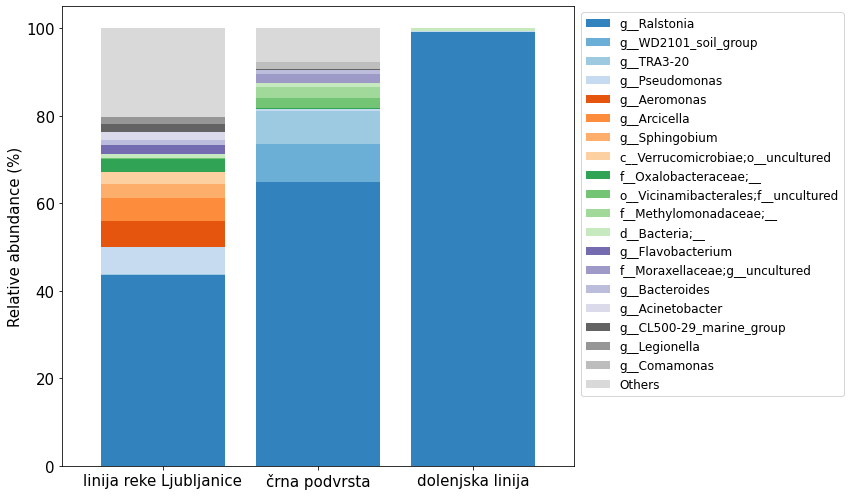

In [30]:
fig, [ax1, ax2,] = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta', 'dolenjska linija'],
    figsize=(10, 7),
    legend=False,
    cmap_name='tab20c'
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta', 'dolenjska linija'],
    figsize=(10, 7),
    legend_short=False,
    cmap_name='tab20c'
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

# custom properties
ax1.tick_params(labelrotation = 0, labelsize=15)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/proteus_all_populations_together_all.png')